In [4]:
from pycbc.inference import sampler
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

In [1]:
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

In [2]:
# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

In [5]:
m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd

Processing H1 data
Processing V1 data
Processing L1 data


In [6]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         }

variable = ('distance',
            'inclination',
            'tc')

prior = JointDistribution(variable,
                SinAngle(inclination=None), 
                Uniform(
                    distance=(10, 100),
                    tc=(m.time-.2, m.time+0.2),
                )
        )

In [7]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [8]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

In [9]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

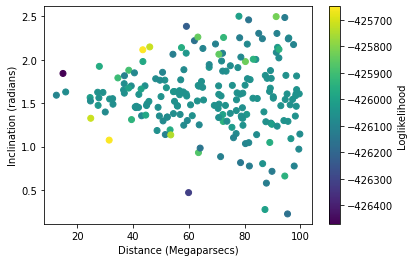

In [10]:
%matplotlib inline
from matplotlib import animation
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(10)
a = pylab.scatter(s['distance'][0,:,0],
                  s['inclination'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Distance (Megaparsecs)')
pylab.ylabel('Inclination (radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['distance'][0,:,i], s['inclination'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['distance'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

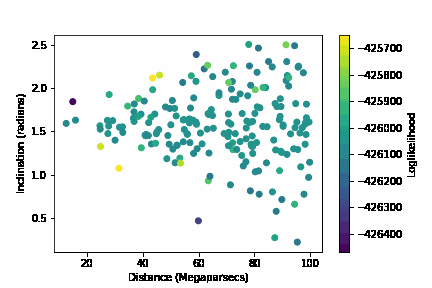

In [11]:
from matplotlib.animation import PillowWriter
from IPython.display import Image

# Note to get this to play, you may need to right click on the image and
# download to your computer or open the image in a new tab of your browser
ani.save('move.gif', writer=PillowWriter(fps=5))
with open('move.gif','rb') as f:
    display(Image(data=f.read(), format='png'))